| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This notebook is licensed under GPL 3.0. Please visit our Github repo for more information: https://github.com/edgi-govdata-archiving/ECHO-COVID19
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

# Tracking EPA's COVID-19 non-enforcement policy
In late March 2020, EPA released a memo announcing that it would not penalize regulated industries that fail to meet their monitoring and reporting requirements due to COVID-19. Specifically EPA said that it:

> "is not seeking penalties for noncompliance only in circumstances that involve routine monitoring and reporting requirements, if, on a case-by-case basis, EPA agrees that such noncompliance was caused by the COVID-19 pandemic."

This may have a number of public and environmental health impacts if facilities respond by increasing their emissions and discharges. Our response to this memo states that the EPA’s COVID-19 leniency is [a “free pass to pollute.](https://envirodatagov.org/epas-covid-19-leniency-is-a-free-pass-to-pollute/)”

Using this notebook, you can track how facilities' releases—as well as monitoring and reporting—of air and water hazards changed over the first few months of the pandemic, compared to previous years. 

There are three scenarios we may see playing out:

_Monitoring and reporting violations_
- 1. **Facilities that do *not* report** (we can track this)....**but do still meet their permit limits** (yet we can't know this specifically, precisely because they didn't report)
- 2. **Facilities that do *not* report** (we can track this)....**and actually exceed their limits** (yet we can't know this specifically, precisely because they didn't report)

_Environmental violations_
- 3. **Facilities that do meet their reporting obligations** BUT they **report having exceeded their permitted limits**. In this case, we can also track whether EPA takes any enforcement action.

We may also see facilities that both meet their reporting obligations and do not exceed their permitted limits. These facilities may still pose a risk to community and environmental health but are not the focus of this investigation. 

This investigation relies upon data from the EPA’s Enforcement & Compliance History Online (ECHO), the primary open data portal supplied by the EPA, and a major basis for EPA’s decisions around enforcement. Please see EPA’s “About the Data” page for known limitations on the data’s quality and completeness. Link to data source (https://echo.epa.gov/tools/data-downloads#downloads) and limitations (https://echo.epa.gov/resources/echo-data/about-the-data)

Organization of this notebook:
 - Air emissions
 - Effluent discharges from major sources 
 - Water quality monitoring and reporting violations
---

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

## Setup
Here we load some helper code to get us going.

In [4]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git &>/dev/null

!pip install geopandas &>/dev/null

import warnings
warnings.filterwarnings('ignore')

from ECHO_modules.get_data import get_echo_data
import pandas as pd
from pandas.errors import EmptyDataError
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.parse

print("Done!")

Done!


## Set the timeframe
We'll look at trends for March and April 2020, corresponding to the early phase of the COVID pandemic and EPA's response to it, and compare them to previous Marches and Aprils.

In [5]:
mnth_name="March and April"

## Are facilities monitoring their air emissions?
Stack tests involve measuring the volume of pollutants coming out of the facility's smokestack.

The following cell will grab EPA data on facility stack tests for every one of the Marches and Aprils on record (up to 19 years ago). Some pollutant releases may be seasonal, so by looking only at March and April, we can account for this variation and ensure an apples-to-apples comparison.

We will only look at data from 2001 on, as EPA notes that its data systems prior to that year are incomplete and hence "unknown."

In [6]:
# Use SQL to search for and select the data about air stack tests
stack_data = None

try:
  sql = 'select * from "ICIS-AIR_STACK_TESTS" where "ACTUAL_END_DATE" like \'03/%\' or "ACTUAL_END_DATE" like \'04/%\''
  # Download the data from that URL
  stack_data = get_echo_data( sql, 'pgm_sys_id' )
except EmptyDataError:
  print( "No data found")

# Filter to just 2001 and later, the years with the most reliable data
if ( stack_data is not None ):
  stack_data["ACTUAL_END_DATE"] = pd.to_datetime(stack_data["ACTUAL_END_DATE"], format="%m/%d/%Y", errors='coerce') # Format the date
  stack_data = stack_data[ pd.DatetimeIndex(stack_data["ACTUAL_END_DATE"]).year >= 2001 ] 

# This is your data!
stack_data

PGM_SYS_ID  ...  AIR_STACK_TEST_STATUS_DESC
0      CT0000000900300005  ...                        Pass
1      CT0000000900300005  ...                        Pass
2      CT0000000900300005  ...                        Pass
3      CT0000000900300005  ...                        Pass
4      CT0000000900300005  ...                        Pass
...                   ...  ...                         ...
85478  GA0000001302500001  ...                        Pass
85479      IL000103020ACJ  ...                        Pass
85480  WANCA0005305700005  ...                        Pass
85481  IA0000001901700030  ...                        Pass
85482  NY0000001472600130  ...                        Pass

[80084 rows x 10 columns]

#### Chart stack tests

The height of each bar will indicate how many tests there were, while the orange line will show us the average number of these since 2001 and the pink line indicates the average for the past three years.

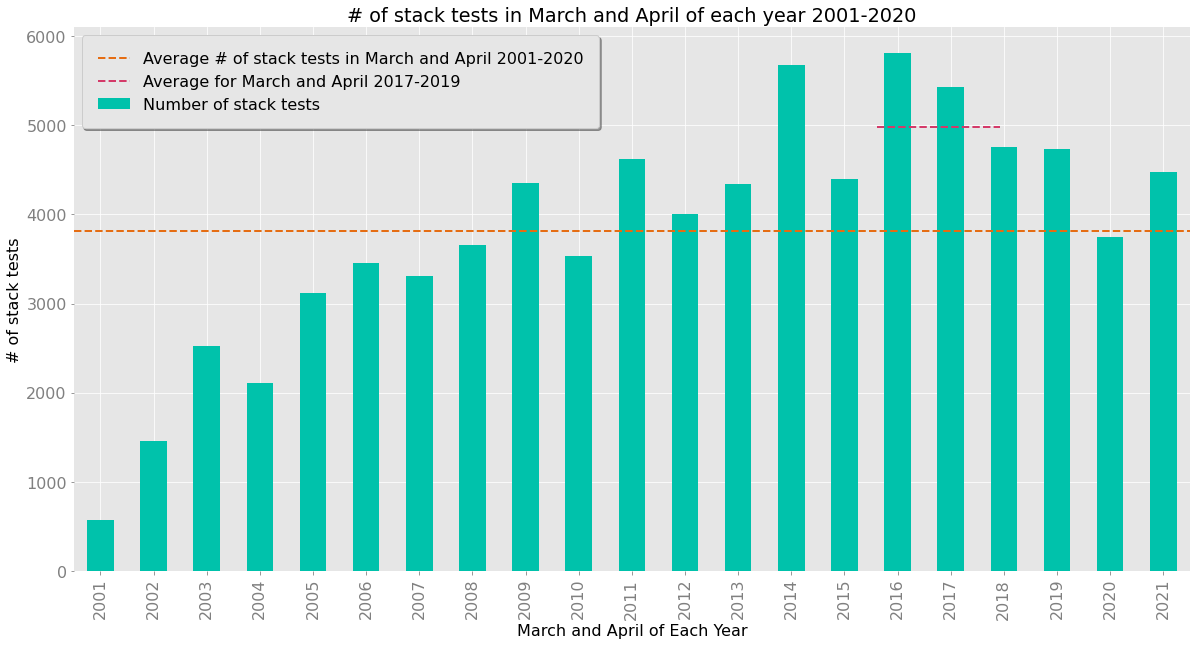

In [11]:
from ECHO_modules.utilities import chart
chart(stack_data, 'ACTUAL_END_DATE', 'STATE_EPA_FLAG', 
  "Number of stack tests", "count", "# of stack tests", mnth_name)

## Are facilities being inspected?
Stack tests may not be happening, but regulators could go in and inspect facilities. Are they conducting inspections?
#### Get the data

In [12]:
eval_data = None
try:
    sql = 'select * from "ICIS-AIR_FCES_PCES" where "ACTUAL_END_DATE" like \'03-%\' or "ACTUAL_END_DATE" like \'04-%\''

    eval_data = get_echo_data( sql, "PGM_SYS_ID" )
except EmptyDataError:
    print( "No data found")

# Filter to just 2001 and later, the years with the most reliable data
if ( eval_data is not None ):
  eval_data["ACTUAL_END_DATE"] = pd.to_datetime(eval_data["ACTUAL_END_DATE"], format="%m-%d-%Y", errors='coerce') # Format the date
  eval_data = eval_data[ pd.DatetimeIndex(eval_data["ACTUAL_END_DATE"]).year >= 2001 ] 

eval_data

ACTIVITY_ID STATE_EPA_FLAG  ... ACTUAL_END_DATE PROGRAM_CODES
PGM_SYS_ID                                      ...                              
020000003402700170   3400559677              S  ...      2001-03-30       CAAMACT
020000003403100168   3400534222              E  ...      2001-03-27        CAACFC
020000003403100941   3400541973              E  ...      2013-04-09       CAAMACT
020000003403100941   3400541974              E  ...      2013-04-19       CAAMACT
020000003403111115   3400527003              E  ...      2013-04-09       CAAMACT
...                         ...            ...  ...             ...           ...
WY0000005604500008   3402392254              S  ...      2014-04-16        CAASIP
WY0005600100026      3601052922              S  ...      2017-04-25        CAATVP
WY0005600100026      3602172748              S  ...      2020-04-07        CAATVP
WY0005602100139      3600726478              S  ...      2016-04-20        CAATVP
0100000009003E0010   3602280806              E  ...      2020-04-09           NaN

[229628 rows x 8 columns]

#### Chart inspections

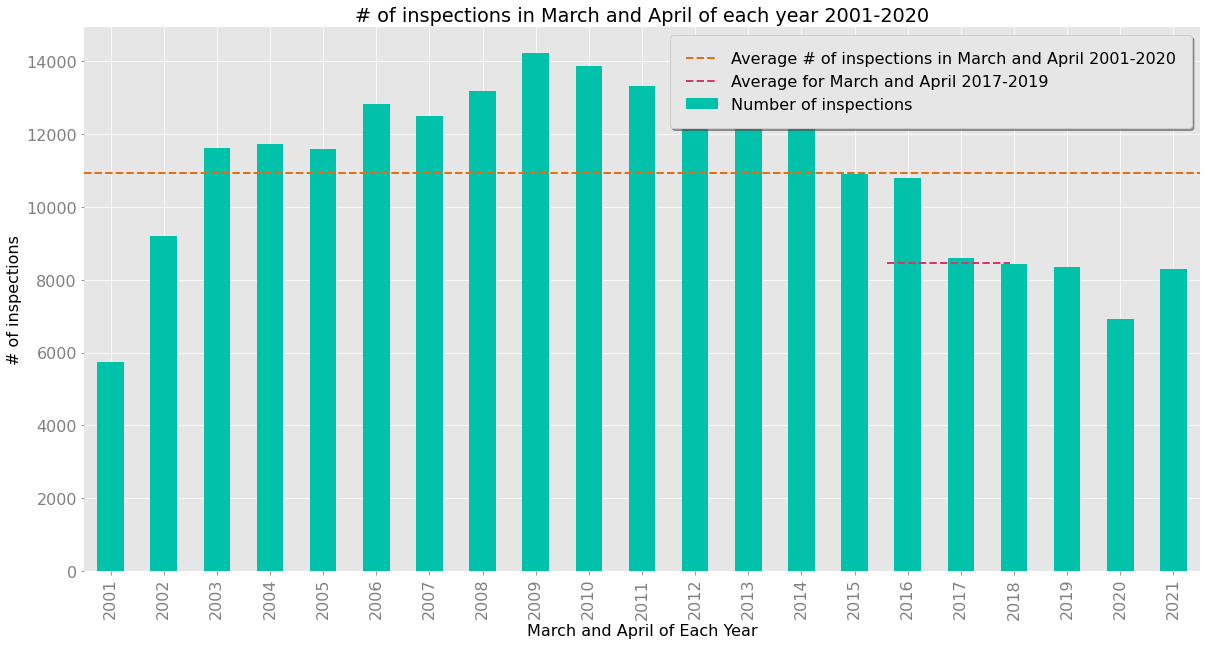

In [13]:
chart(eval_data, 'ACTUAL_END_DATE', 'ACTIVITY_TYPE_DESC', 
  "Number of inspections", "count", "# of inspections", mnth_name)

## What have facilities reported releasing into the air?
Air pollution is associated with greater virulence of COVID-19. What are facilities releasing into the air in spite of this greater risk to human life?

We'll start by looking at those facilities that were found to be in violation for their emissions.

In [20]:
air_data = None

try:
    sql = 'select * from "ICIS-AIR_VIOLATION_HISTORY" where "HPV_DAYZERO_DATE" like \'03-%\' or "HPV_DAYZERO_DATE" like \'04-%\''

    air_data = get_echo_data( sql, "PGM_SYS_ID" )

    # Remove "FACIL" violations, which are paperwork violations according to: https://19january2017snapshot.epa.gov/sites/production/files/2013-10/documents/frvmemo.pdf
    air_data = air_data.loc[(air_data["POLLUTANT_DESCS"]!="FACIL")]
except EmptyDataError:
    print( "No data found")

# Filter to just 2001 and later, the years with the most reliable data
if ( air_data is not None ):
  air_data["HPV_DAYZERO_DATE"] = pd.to_datetime(air_data["HPV_DAYZERO_DATE"], format="%m-%d-%Y", errors='coerce') # Format the date
  air_data = air_data[ pd.DatetimeIndex(air_data["HPV_DAYZERO_DATE"]).year >= 2001 ] 

air_data

ACTIVITY_ID  ... HPV_RESOLVED_DATE
PGM_SYS_ID                       ...                  
IL000031600ASD       3400337995  ...        07-29-2003
IL000031096AKZ       3400338004  ...        03-31-2004
IN0000001803300043   3400346466  ...        08-18-2006
IN0000001803300043   3400346474  ...        05-19-2006
IN0000001803300043   3602082630  ...               NaN
...                         ...  ...               ...
CABAA424710          3602050949  ...        01-31-2018
CABAA424710          3602050960  ...        01-31-2018
SC00019000284        3602294109  ...               NaN
AL0000000112900011   3602710500  ...               NaN
SC00008200079        3602489054  ...               NaN

[2706 rows x 13 columns]

#### Chart emissions violations
The height of each bar indicates how many emissions violations there have been. The orange line shows the average number of emissions violations since 2001, and the pink line indicates the average for the past three years.

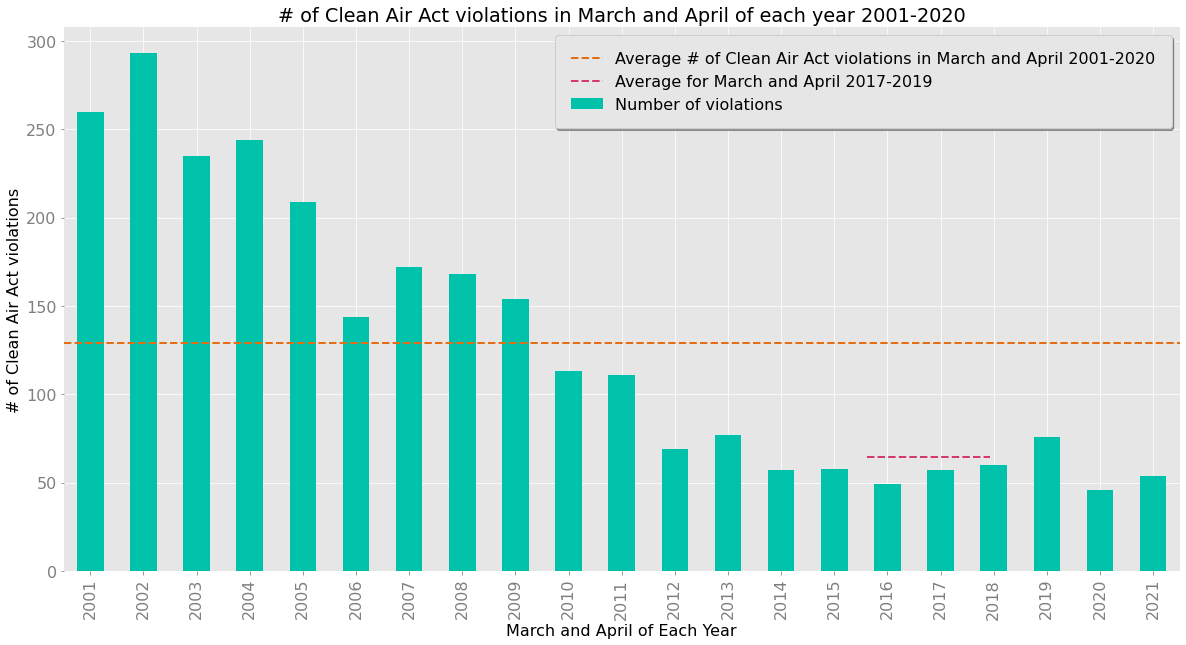

In [21]:
chart(air_data, 'HPV_DAYZERO_DATE', 'ENF_RESPONSE_POLICY_CODE', 
  "Number of violations", "count", "# of Clean Air Act violations", mnth_name)

#### Let's focus on March and April for just this year (2020) and break it down by type of pollutant whose levels were exceeded.
In other words, we'll zoom in on the right-most bar in the above chart and show what pollutants facilities released, causing these Clean Air Act violations.

In [22]:
latest = air_data[(air_data["HPV_DAYZERO_DATE"] >= '2020') & (air_data["HPV_DAYZERO_DATE"] < '2021')]

pollutants = latest.groupby(['POLLUTANT_DESCS'])[['ACTIVITY_ID']].count()
pollutants = pollutants.rename(columns={'ACTIVITY_ID': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)

fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels = ax.pie(pollutants["Violations"], labels = pollutants.index, radius = 5);
for pos,lab in enumerate(labels):
    if pos < 10:
        lab.set_fontsize(96)
    else:
        lab.set_fontsize(0)

#### Where are these facilities that exceeded their permits?
Even if, on the whole, there are fewer exceedances, the places that are emitting more pollutants are important to track.

Run the next two cells to set up the analysis. The first one may take some time to run, since it is capturing data for several hundred thousand facilities across the US.

In [23]:
# Get everything we will need from ECHO_EXPORTER in a single DB query.
# We can then use the full dataframe to specialize views of it.
full_echo_data = None

column_mapping = {
    '"REGISTRY_ID"': str,
    '"FAC_NAME"': str,
    '"FAC_LAT"': float,
    '"FAC_LONG"': float,
    '"AIR_IDS"': str,
    '"NPDES_IDS"': str,
    '"CAA_QTRS_WITH_NC"': float,
    '"CWA_QTRS_WITH_NC"': float,
    '"FAC_QTRS_WITH_NC"': float,
    '"DFR_URL"': str,
    '"AIR_FLAG"': str,
    '"NPDES_FLAG"': str
}
column_names = list( column_mapping.keys() )
columns_string = ','.join( column_names )

sql = 'select ' + columns_string + ' from "ECHO_EXPORTER" where "AIR_FLAG" = \'Y\' or "NPDES_FLAG" = \'Y\''

try:
    # Don't index.
    full_echo_data = get_echo_data( sql )
except EmptyDataError:
    print("\nThere are no EPA facilities for this query.\n")

print("Done! Proceed to run the next cell")

Done! Proceed to run the next cell


In [25]:
# Focus on air violations in 2020
latest = air_data[(air_data["HPV_DAYZERO_DATE"] >= '2020') & (air_data["HPV_DAYZERO_DATE"] < '2021')]

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
  # Get facility information from ECHO
  air_echo_data = full_echo_data[ full_echo_data['AIR_FLAG'] == 'Y' ].copy().reset_index( drop=True )
  # Filter ECHO EXPORTER data to rows containing AIR_IDs from latest air_data
  idxs=set() # Use a set to get unique index positions in ECHO_EXPORTER (i.e. unique facilities)
  for index,value in air_echo_data["AIR_IDS"].items(): # For each record
    for i in value.split(): # For each AIR_ID in the record
      if i in ids: # If the AIR_ID is in the list of non-reporters
        idxs.add(index) # Add its E_E position
  idxs=list(idxs)
  latest = air_echo_data.iloc[idxs,:] # Instead of join, just use E_E, since we don't need the reporting details to map facilities
  qnc = latest # For later analysis of non-compliance trends
  display(latest)
    
else:
    print("Actually, there were no permit exceedences for %s" %(mnth_name))

REGISTRY_ID  ... NPDES_FLAG
247681  1.100003e+11  ...          Y
54019   1.100006e+11  ...          Y
247683  1.100420e+11  ...          Y
215183  1.100405e+11  ...          Y
237455  1.100144e+11  ...          Y
214161  1.100180e+11  ...          Y
23826   1.100007e+11  ...          Y
190610  1.100065e+11  ...          N
229526  1.100020e+11  ...          Y
237976  1.100555e+11  ...          N
230816  1.100435e+11  ...          Y
82593   1.100004e+11  ...          Y
223522  1.100005e+11  ...          Y
238368  1.100174e+11  ...          Y
76839   1.100012e+11  ...          N
234284  1.100005e+11  ...          N
71854   1.100005e+11  ...          Y
229683  1.100013e+11  ...          Y
228154  1.100024e+11  ...          N
79681   1.100004e+11  ...          Y
147138  1.100641e+11  ...          N
82755   1.100004e+11  ...          Y
239172  1.100157e+11  ...          Y
147654  1.100707e+11  ...          N
236486  1.100004e+11  ...          Y
198858  1.100123e+11  ...          Y
87883   1.100105e+11  ...          Y
82764   1.100004e+11  ...          Y
248523  1.100003e+11  ...          Y
237391  1.100003e+11  ...          N
1875    1.100292e+11  ...          N
214483  1.100292e+11  ...          Y
205013  1.100004e+11  ...          N
238550  1.100133e+11  ...          Y
166242  1.100702e+11  ...          N
211938  1.100019e+11  ...          Y
207589  1.100004e+11  ...          Y
233701  1.100004e+11  ...          N
238697  1.100669e+11  ...          Y
113264  1.100008e+11  ...          N
239474  1.100254e+11  ...          Y
247287  1.100110e+11  ...          Y
207736  1.100060e+11  ...          Y
118009  1.100587e+11  ...          N
237821  1.100570e+11  ...          Y
236287  1.100005e+11  ...          Y

[46 rows x 12 columns]

#### Make the map!
The map shows us all the facilities that report emitting more than their permitted levels in March and April 2020.

In [26]:
from ECHO_modules.utilities import mapper

# Collect and count facilities without geo coordinate information
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")

# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]
print("There are "+str(len(latest))+" facilities mapped below.")

map_of_facilities = mapper(latest)
map_of_facilities

There are 0 facilities we can't map because they have incomplete data
There are 46 facilities mapped below.


#### Of these known violators, how many quarters have they spent in non-compliance recently^?
These may be habitually "bad actors" who should not be let off the hook (but likely will be given EPA's non-enforcement policy)

^ Unfortunately, due to the nature of EPA's database, "recently" refers to the previous 12 quarters from the *current point in time* We are unable to access summary information about compliance for the 12 quarters prior to the beginning of the pandemic in the spring of 2020.

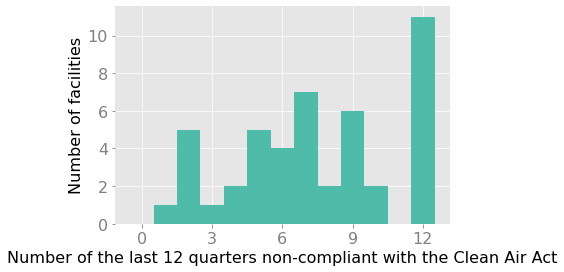

In [27]:
bad_actors = qnc.groupby(qnc.index)[["CAA_QTRS_WITH_NC"]].mean()
bad_actors = bad_actors[~(np.isnan(bad_actors["CAA_QTRS_WITH_NC"]))]

plt.hist(bad_actors["CAA_QTRS_WITH_NC"], density=False, bins=np.arange(14)-0.5);
plt.xticks([0,3,6,9,12])
plt.ylabel('Number of facilities')
plt.xlabel('Number of the last 12 quarters non-compliant with the Clean Air Act');

---

## What are facilities releasing into the water?

*NOTE*: Because there are so many facilities that discharge into waters of the US, there's a lot of data! The following cell may take a little while to run.

In [28]:
# Find facilities with pollutant exceedences
exceeds = None

try:
  sql = 'select "NPDES_ID", "EXCEEDENCE_PCT", "MONITORING_PERIOD_END_DATE", ' + \
  '"PARAMETER_DESC" from "NPDES_EFF_VIOLATIONS" where "EXCEEDENCE_PCT" > 0 ' + \
  'and ("MONITORING_PERIOD_END_DATE" like \'03/%\' or "MONITORING_PERIOD_END_DATE" like \'04/%\')'
  exceeds = get_echo_data( sql, "NPDES_ID" )
except EmptyDataError:
  print( "No data found")

# Filter to just 2001 and later, the years with the most reliable data
if ( exceeds is not None ):
  exceeds["MONITORING_PERIOD_END_DATE"] = pd.to_datetime(exceeds["MONITORING_PERIOD_END_DATE"], format="%m/%d/%Y", errors='coerce') # Format the date
  exceeds = exceeds[ pd.DatetimeIndex(exceeds["MONITORING_PERIOD_END_DATE"]).year >= 2001 ] 
   
exceeds

No data found


#### Chart Clean Water Act exceedances
Are facilities exceeding their permits more this month in 2020 than previous years? Like with air emissions and monitoring, we need to compare month-month (e.g. March/April 2019 to March/April 2020) because there is a seasonality to many discharges.

The height of each bar will indicate how many pollution permits have been exceeded, while the orange line will show us the average number of these since 2001 and the pink line indicates the average for the past three years.

In [ ]:
chart(exceeds, 'MONITORING_PERIOD_END_DATE', 'EXCEEDENCE_PCT', 
  "Number of pollution permits exceeded", "count", "# of permit exceedances", mnth_name)

#### Let's look at March and April for just this year (2020) and break it down by type of pollutant.
That is, we're going to zoom in on the rightmost bar in the bar charts above.

In [ ]:
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2021')]

pollutants = latest.groupby(['PARAMETER_DESC'])[['MONITORING_PERIOD_END_DATE']].count()
pollutants = pollutants.rename(columns={'MONITORING_PERIOD_END_DATE': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)

fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels = ax.pie(pollutants["Violations"], labels = pollutants.index, radius = 5);
for pos,lab in enumerate(labels):
  if pos < 10:
    lab.set_fontsize(96)
  else:
    lab.set_fontsize(0)

#### Where are the facilities that are currently exceeding their Clean Water Act emissions?
Remember, these are only the facilities that chose to report exceedances. Under the current policy, facilities can be not reporting at all, legally.

In [ ]:
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2021')]

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
  # Get facility information from ECHO
  water_echo_data = full_echo_data[ full_echo_data['NPDES_FLAG'] == 'Y' ].copy().reset_index( drop=True )

  # Filter ECHO EXPORTER data to rows containing pgm_sys_ids from latest  
  idxs=set() # Use a set to get unique index positions in ECHO_EXPORTER (i.e. unique facilities)
  for index,value in water_echo_data["NPDES_IDS"].items(): # For each record in E_E
    for i in value.split(): # For each NPDES_ID in the record
      if i in ids: # If the NPDES_ID is in the list of non-reporters
        idxs.add(index) # Add its E_E position
  idxs=list(idxs)
  latest = water_echo_data.iloc[idxs,:] # Instead of join, just use E_E, since we don't need the reporting details to map facilities
  qnc = latest # For later analysis of non-compliance trends
  display(latest)
    
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

In [ ]:
# Count facilities without geo coordinate information
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")

# Remove facilities without coordinates
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+" facilities mapped below.")

map_of_facilities = mapper(latest)
map_of_facilities

#### Of these known violators, how many quarters have they spent in non-compliance recently?
These may be habitually "bad actors" who should not be let off the hook (but likely will be given EPA's non-enforcement policy)

In [ ]:
bad_actors = qnc.groupby(qnc.index)[["CWA_QTRS_WITH_NC"]].mean()
bad_actors = bad_actors[~(np.isnan(bad_actors["CWA_QTRS_WITH_NC"]))]

plt.hist(bad_actors["CWA_QTRS_WITH_NC"], density=False, bins=np.arange(14)-0.5);
plt.xticks([0,3,6,9,12])
plt.ylabel('Number of facilities')
plt.xlabel('Number of the last 12 quarters non-compliant with the Clean Water Act');

## Are facilities monitoring and reporting water quality?
We'll look at how facilities regulated under the Clean Water Act have altered their required monitoring practices.

Run the code in the cells below, which will query our copy of the ECHO database and pull information on regulated facilities.

First, we'll find records of facilities violating their permits due to missing reports such as Annual Inspection Certificates and CAFO annual reports. In this case, the "N" we are looking for in our query does NOT mean no - it just is a code for the kind of violation event we're interested in (non-reporting).

Second, we'll find records of facilities violating their permits due to "Non-Receipt of DMR (Discharge Monitoring Reports)/Schedule Report" and are required by the CWA's National Pollutant Discharge Elimination System (NPDES).

Not submitting these reports on schedule can lead to "Reportable Non-Compliance" with NPDES and CWA. According to the EPA, "DMR values not received within 31 days of the DMR form due date result in the generation of a violation code (D80 or D90). ICIS-NPDES identifies these DMR non-receipt violations and automatically creates violation codes for the missing DMR values with monitoring requirements (D80) and missing DMR values with effluent limits (D90). EPA's data sharing policy allows states a 40-day window to report DMR values to EPA's data system; therefore, DMR values reported on time to state agencies and shared with EPA within 40 days do not contribute to permit level noncompliance status."

In [30]:
report_data = None

try:
  sql = 'select "NPDES_ID", "SCHEDULE_DATE", "RNC_DETECTION_CODE"' + \
  ' from "NPDES_PS_VIOLATIONS" where "RNC_DETECTION_CODE" = \'N\' and' + \
  ' (extract(month from "SCHEDULE_DATE") = 3 or extract(month from "SCHEDULE_DATE") = 4)'
  report_data = get_echo_data( sql, "NPDES_ID" )
except EmptyDataError:
  print( "No data found")

# Filter to just 2001 and later, the years with the most reliable data
if ( report_data is not None ):
  report_data["SCHEDULE_DATE"] = pd.to_datetime(report_data["SCHEDULE_DATE"], format="%Y-%m-%d", errors='coerce') # Format the date
  report_data = report_data[ pd.DatetimeIndex(report_data["SCHEDULE_DATE"]).year >= 2001 ] 

report_data

SCHEDULE_DATE RNC_DETECTION_CODE
NPDES_ID                                  
PR0021326    2006-04-01                  N
NH0100871    2001-04-15                  N
MA0100013    2001-03-31                  N
PR0024643    2007-03-01                  N
MA0100633    2004-04-01                  N
...                 ...                ...
MO0117455    2021-04-01                  N
NJG145211    2021-03-31                  N
NJG113786    2021-03-31                  N
NJG134066    2019-03-31                  N
MO0101567    2021-04-01                  N

[12855 rows x 2 columns]

#### Chart this ^ !!!
It's all well and good to have this table, but it's hard to pick out patterns from tabular data. Let's plot it as a histogram in order to see what's going on.

The height of each bar will indicate how many facilities were out of compliance due to missing or late reports, while the orange line will show us the average number of these facilities for since 2001 and the pink line indicates the average for the past three years or so.

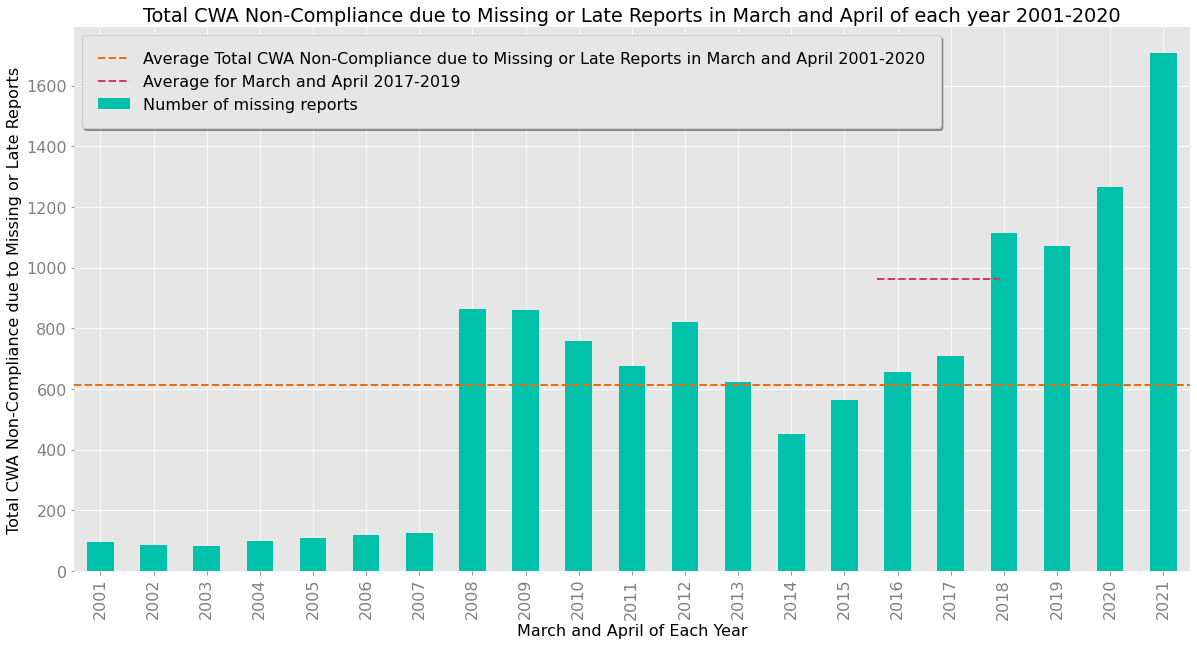

In [31]:
chart(report_data, 'SCHEDULE_DATE', 'RNC_DETECTION_CODE', "Number of missing reports", 
  "count", "Total CWA Non-Compliance due to Missing or Late Reports", mnth_name)

#### Which facilities didn't submit reports in March or April of 2020?
First, let's get more information about those facilities.

In [32]:
latest = report_data[(report_data['SCHEDULE_DATE'] >= '2020') & (report_data['SCHEDULE_DATE'] < '2021')]

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
  # Get facility information from ECHO
  echo_data = full_echo_data[ full_echo_data['NPDES_FLAG'] == 'Y' ].copy().reset_index( drop=True )
  
  idxs=set() # Use a set to get unique index positions in ECHO_EXPORTER (i.e. unique facilities)
  for index,value in echo_data["NPDES_IDS"].items(): # For each record in E_E
    for i in value.split(): # For each NPDES_ID in the record
      if i in ids: # If the NPDES_ID is in the list of non-reporters
        idxs.add(index) # Add its E_E position
  idxs=list(idxs)
  latest = echo_data.iloc[idxs,:] # Instead of join, just use E_E and replace latest, since we don't need the reporting details to map facilities

  display(latest)
    
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

REGISTRY_ID                   FAC_NAME  ...  AIR_FLAG  NPDES_FLAG
528384  1.100168e+11             JOHNNYS MARINA  ...         N           Y
655360  1.100015e+11              SCHAIRER BROS  ...         Y           Y
643075  1.100042e+11     663 CRESCENT PLAZA LLC  ...         N           Y
12292   1.100702e+11        DAPPER BUS FACILITY  ...         N           Y
489478  1.100067e+11                 VASHON STP  ...         N           Y
...              ...                        ...  ...       ...         ...
686067  1.100110e+11            CITY OF ARTESIA  ...         N           Y
63476   1.100305e+11             AMERICYCLE INC  ...         N           Y
51189   1.100702e+11    STAR RAVIOLI MFG CO INC  ...         N           Y
305149  1.100420e+11                   CHEMETCO  ...         Y           Y
700415  1.100008e+11  EDMONDS COMMUNITY COLLEGE  ...         N           Y

[942 rows x 12 columns]

#### Map them!
Now we'll map those facilities that didn't submit things like Annual Inspection Certifications in March and April of 2020.

In [33]:
# Count facilities without geo coordinate information
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")

# Remove facilities without coordinates
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+" facilities mapped below.")

map_of_facilities = mapper(latest)
map_of_facilities

There are 0 facilities we can't map because they have incomplete data
There are 942 facilities mapped below.


Now let's look at missing Discharge Monitoring Reports. These really important reports, often submitted monthly, are supposed to include detailed information on for each permitted pollutant.

In [69]:
dmr_data = None

try:
  sql = 'select "NPDES_ID", "MONITORING_PERIOD_END_DATE", "NODI_CODE", "VIOLATION_CODE", "RNC_DETECTION_CODE"' + \
  ' from "NPDES_EFF_VIOLATIONS" where' + \
  ' "MONITORING_PERIOD_END_DATE" like \'03/%\' or "MONITORING_PERIOD_END_DATE" like \'04/%\''
  dmr_data = get_echo_data( sql, "NPDES_ID" )
except EmptyDataError:
  print( "No data found")

dmr_data

No data found


Process this data a bit.

In [ ]:
d = dmr_data.loc[(dmr_data['VIOLATION_CODE'] == 'D80') | (dmr_data['VIOLATION_CODE'] == 'D90')] #https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary Required monitoring DMR value overdue / Limited value overdue	
d = d.loc[(d['RNC_DETECTION_CODE'] == 'K') | (d['RNC_DETECTION_CODE'] == 'N')] #https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary. 	Non-receipt Violation, Non-Monthly Average / Non-Receipt of DMR/Schedule Report

#x = x.loc[(x['MONITORING_PERIOD_END_DATE'].str.contains("03/")) | (x['MONITORING_PERIOD_END_DATE'].str.contains("04/"))]
#z = x.loc[(x['NODI_CODE']=='Z')]
f = d.reset_index()
f["MONITORING_PERIOD_END_DATE"] = pd.to_datetime(d['MONITORING_PERIOD_END_DATE'], format="%m/%d/%Y")
f = f.groupby("MONITORING_PERIOD_END_DATE")[["NPDES_ID"]].agg("nunique")
f = f.resample("Y").sum()
d

Chart all these missing DMRs, first in total, and then by the number of facilities failing to report them.

In [ ]:
chart(d, 'MONITORING_PERIOD_END_DATE', 'MONITORING_PERIOD_END_DATE', 
  "# of late or missing DMRs", "count", "Number of late or missing DMRs", mnth_name)

In [ ]:
title ="Number of facilities with late or missing DMRs"

# Organize the data
#f.index = f.index.strftime('%Y') # Make the x axis (date) prettier
f = f.loc[f.index >= '2001']
f= f.rename(columns={"NPDES_ID": "Facilities"})

# Create the chart
ax = f.plot(kind='bar', title = ""+title+" in %s of each year 2001-2020" %(mnth_name), figsize=(20, 10), fontsize=16, color=colour)
ax

# Label trendline
trend=f["Facilities"].mean()
ax.axhline(y=trend, color='#e56d13', linestyle='--', label = "Average "+title+" in %s 2001-2020" %(mnth_name))

# Label the previous three years' trend (2017, 2018, 2019)
trend_month=pd.concat([f.loc["2017"],f.loc["2018"],f.loc["2019"]])
trend_month=trend_month["Facilities"].mean()
ax.axhline(y=trend_month, xmin = .82, xmax=.93, color='#d43a69', linestyle='--', label = "Average for %s 2017-2019" %(mnth_name))

# Label plot
ax.legend()
ax.set_xlabel("March and April of Each Year")
ax.set_ylabel(title)

## Which facilities have officially indicated that they could not monitor and report water quality due to COVID?
Facilities are allowed to indicate to the EPA that they were unable to submit water discharge monitoring reports because of COVID-related reasons.

In [34]:
# Use NPDES_DMR_FY2020 to show the facilities that indicated they could not monitor and report due to COVID
z_data = None

try:
  sql = 'select *' + \
  ' from "NPDES_DMRS_FY2020" where "NODI_CODE" = \'Z\' and ' + \
  ' ("MONITORING_PERIOD_END_DATE" like \'03/%\' or "MONITORING_PERIOD_END_DATE" like \'04/%\')'

  z_data = get_echo_data( sql, "EXTERNAL_PERMIT_NMBR" )
  count = len(z_data.index.unique())
  print("There are "+str(count)+" permittees that officially indciated they could not monitor and report on water quality due to COVID. Here are their records:")
except EmptyDataError:
    print( "No data found")

z_data

There are 348 permittees that officially indciated they could not monitor and report on water quality due to COVID. Here are their records:


ACTIVITY_ID  ...  RNC_RESOLUTION_DATE
EXTERNAL_PERMIT_NMBR               ...                     
AKG332020              3601076511  ...                  NaN
AKG332020              3601076511  ...                  NaN
AKG332020              3601076511  ...                  NaN
AKG332020              3601076511  ...                  NaN
AKG332020              3601076511  ...                  NaN
...                           ...  ...                  ...
WVR030017              3600795812  ...                  NaN
WVR030017              3600795812  ...                  NaN
WVR030017              3600795812  ...                  NaN
WVR030017              3600795812  ...                  NaN
WVR030017              3600795812  ...                  NaN

[4894 rows x 56 columns]

#### What kinds of water pollutants were these facilities not able to report on?

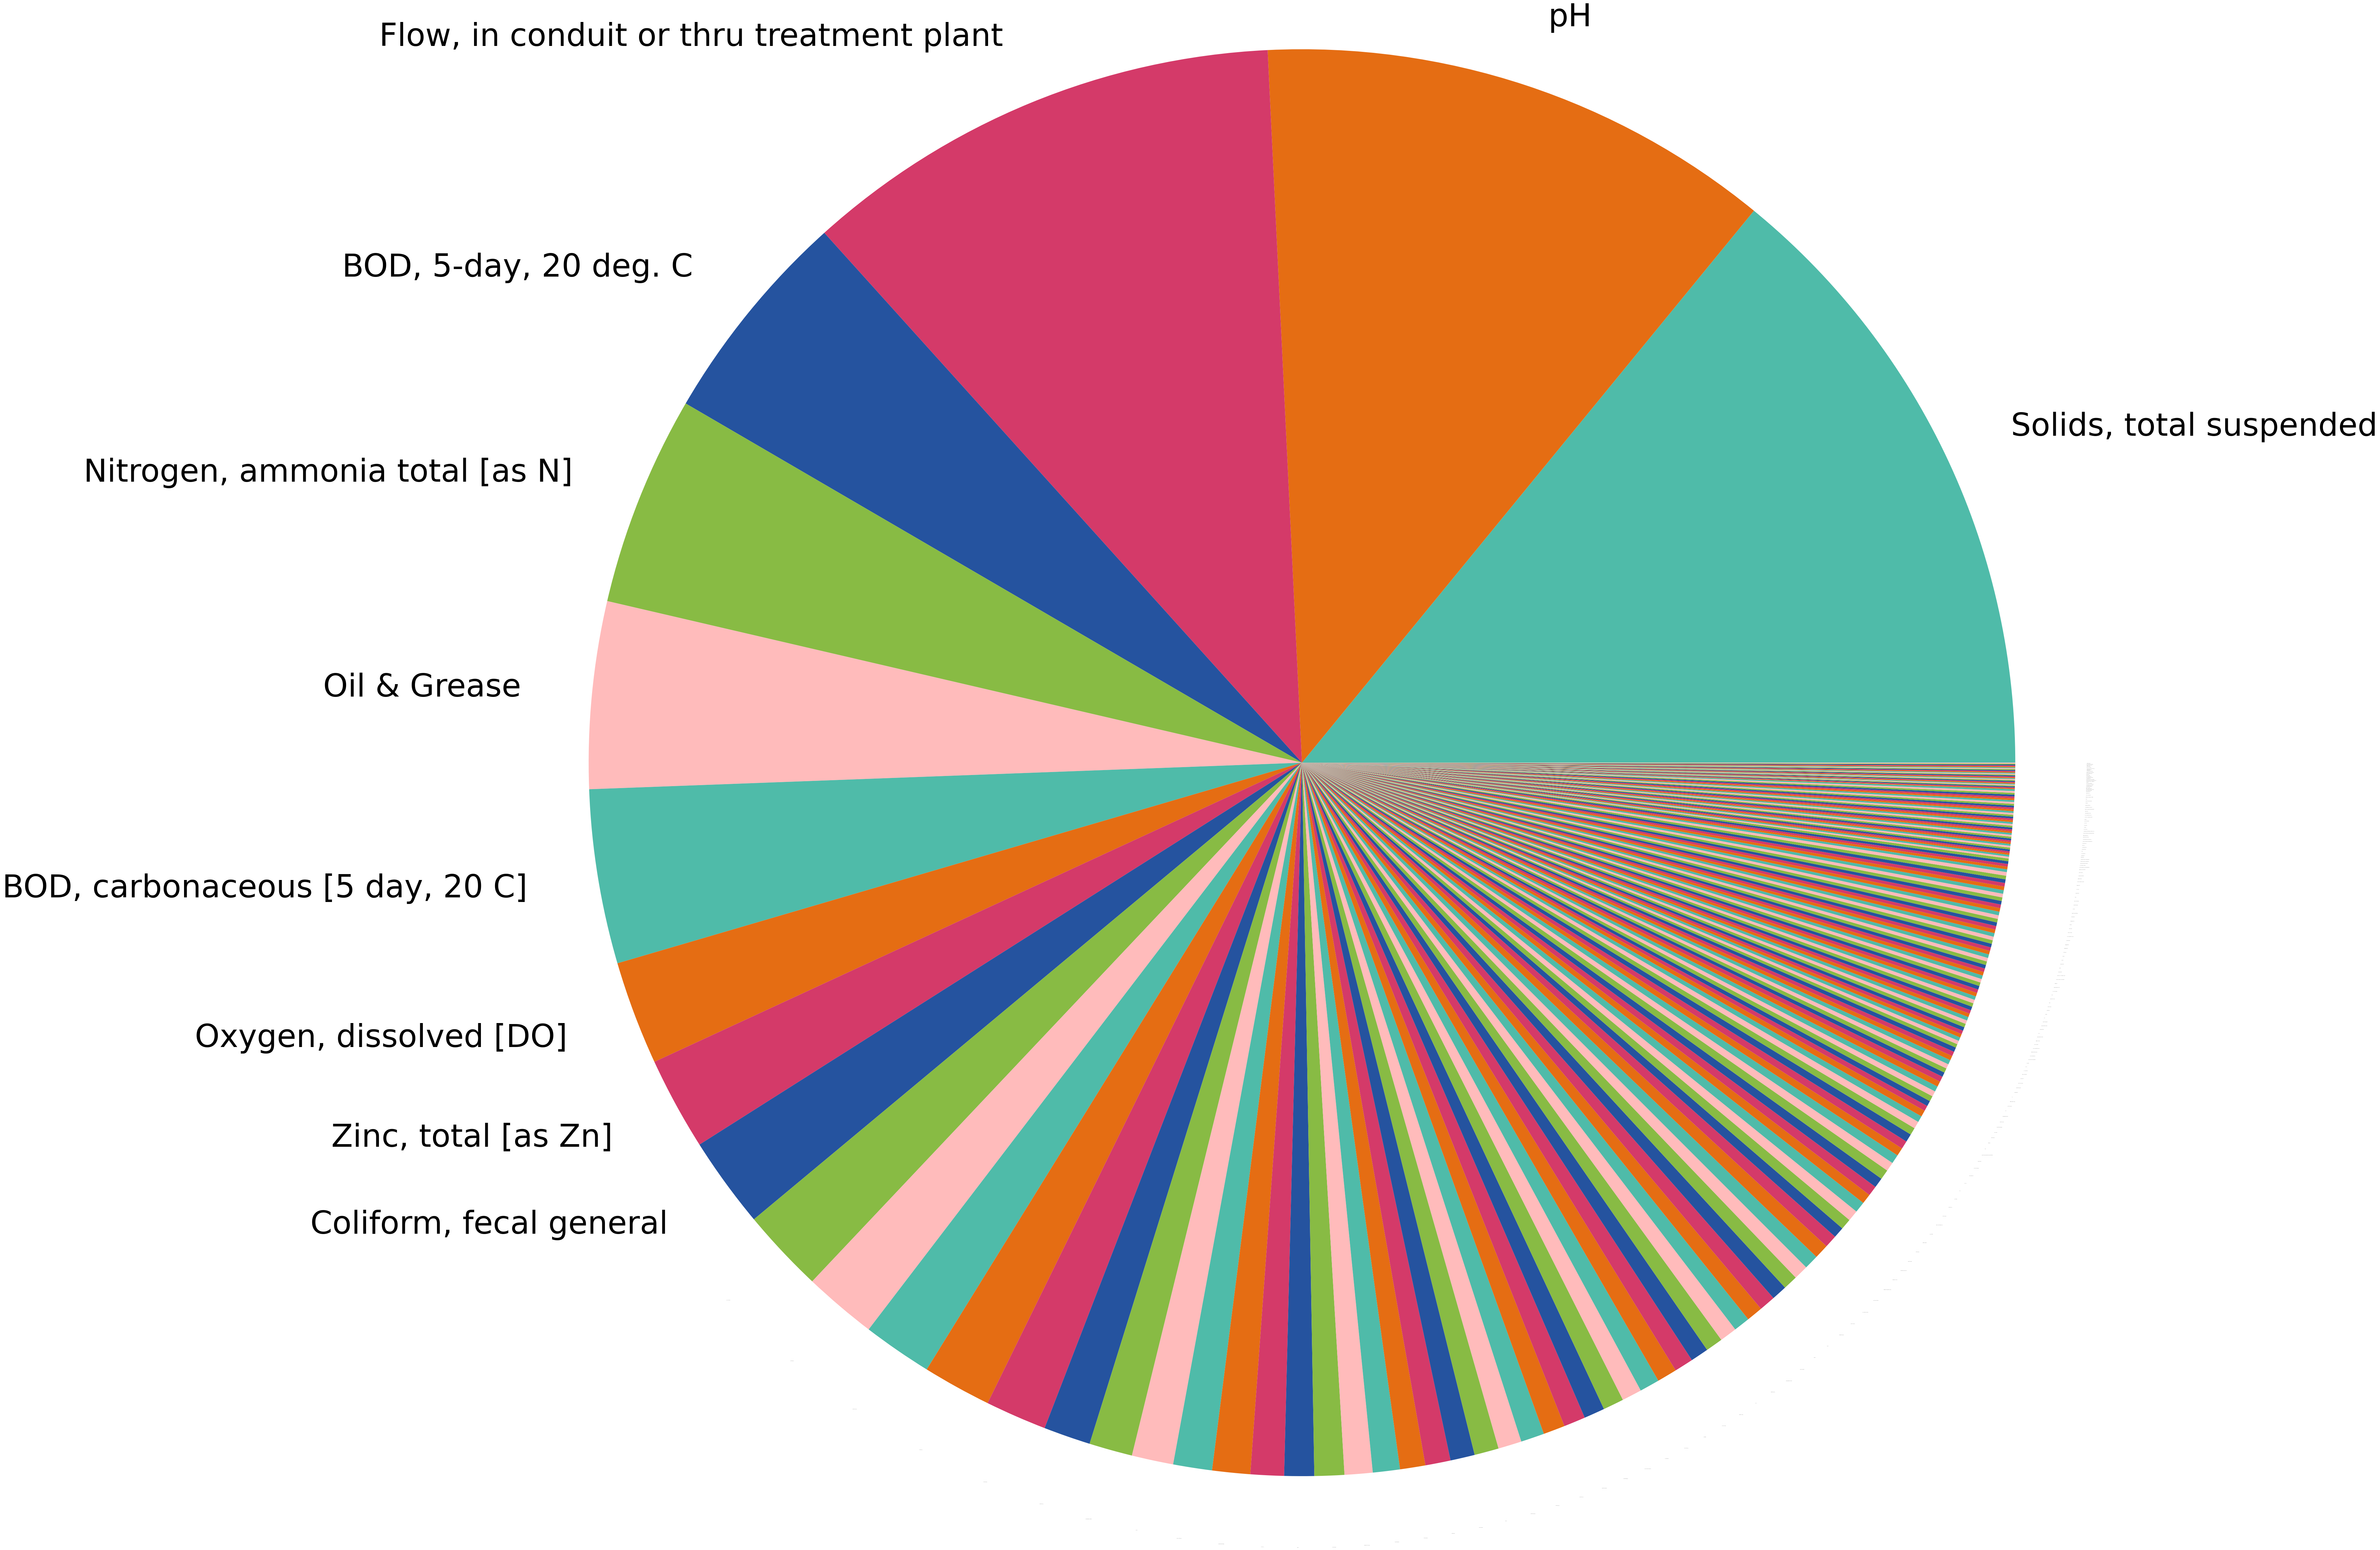

In [35]:
pollutants = z_data.groupby(['PARAMETER_DESC'])[['MONITORING_PERIOD_END_DATE']].count()
pollutants = pollutants.rename(columns={'MONITORING_PERIOD_END_DATE': "Violations"})
pollutants = pollutants.sort_values(by='Violations', ascending=False)

fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
wedges, labels = ax.pie(pollutants["Violations"], labels = pollutants.index, radius = 5);
for pos,lab in enumerate(labels):
  if pos < 10:
    lab.set_fontsize(96)
  else:
    lab.set_fontsize(0)

#### Where are these facilities?
Run the next two cells back to back.

In [36]:
latest = z_data

# Pull out Ids to match ECHO_EXPORTER
ids = latest.index.unique()

if (len(latest.index)>0):
  # Get facility information from ECHO
  echo_data = full_echo_data[ full_echo_data['NPDES_FLAG'] == 'Y' ].copy().reset_index( drop=True )
  # Filter ECHO EXPORTER data to rows containing NPDES IDs from latest / z_data  
  idxs=set() # Use a set to get unique index positions in ECHO_EXPORTER (i.e. unique facilities)
  for index,value in echo_data["NPDES_IDS"].items(): # For each record in E_E
    for i in value.split(): # For each NPDES_ID in the record
      if i in ids: # If the NPDES_ID is in the list of non-reporters
        idxs.add(index) # Add its E_E position
  idxs=list(idxs)
  latest = echo_data.iloc[idxs,:] # Instead of join, just use E_E and replace latest, since we don't need the reporting details to map facilities
  display(latest)
else:
    print("Actually, there were no reporting violations for %s" %(mnth_name))    

REGISTRY_ID                               FAC_NAME  ...  AIR_FLAG  NPDES_FLAG
151556  1.100649e+11           SORRENTO LUMBER COMPANY INC.  ...         N           Y
407569  1.100097e+11          CAMPBELL HILL STP, VILLAGE OF  ...         N           Y
575522  1.100672e+11  TO-RICOS, LTD (LAS PIEDRAS FEED MILL)  ...         N           Y
213039  1.100398e+11                    JEFFERSON CITY RWRF  ...         N           Y
630845  1.100433e+11           SORRENTO LUMBER COMPANY INC.  ...         N           Y
...              ...                                    ...  ...       ...         ...
425954  1.100231e+11                   GRAND VALLEY ESTATES  ...         N           Y
677868  1.100700e+11       SCHUSTER CONCRETE READY MIX, LLC  ...         N           Y
583669  1.100109e+11                        WATER WAYS PARK  ...         N           Y
655353  1.100024e+11                      L&L IRONWORKS LLC  ...         Y           Y
163835  1.100371e+11                   J & V AUTO PARTS INC  ...         N           Y

[343 rows x 12 columns]

In [37]:
# Count facilities without geo coordinate information
missing = latest[(np.isnan(latest["FAC_LAT"])) | (np.isnan(latest["FAC_LONG"]))]
count = missing.index.unique()
print("There are "+str(len(count))+" facilities we can't map because they have incomplete data")

# Remove facilities without coordinates
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))] # Filter to remove NaNs - missing data!
print("There are "+str(len(latest))+" facilities mapped below.")

map_of_facilities = mapper(latest)
map_of_facilities

There are 0 facilities we can't map because they have incomplete data
There are 343 facilities mapped below.
